# Part II: Analyzing energy policy options in Central Asia

This tutorial is designed to show how one can use the open MESSAGEix energy-water model of Central Asia (MESSAGEix-CAS) for analyzing different policy options. This tutorial includes instructions for:
- loading the MESSAGEix-CAS Baseline scenario and cloning it
- changing/editing the input data, and saving the changes
- adding renewable energy policies, such as subsidies and share constraints
- adding emission targets
- postprocessing and visualization of some output results

<img src='_static/re.jpg' style="width: 600px;"/>

Source of images Dreamstime, designed by Adam Islaam.

## 1. Importing software packages and loading Baseline

For running this tutorial, you need to have:
- The `message_ix` modeling framework installed sucessfully with a version >= 3.4.0 (see instructions [here](https://docs.messageix.org/en/stable/#getting-started) ).
- Updated your code by pulling modifications done for this study from [this fork](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper).

*Notice*: If you have installed `message_ix` using Anaconda/miniconda, and you are a proficient user of `git` to pull the changes from the abovementioned fork automatically, you can update your code manually. For doing so, you need to copy the following folder and file from the fork and replace the ones on your machine:
- `message_ix/model/MESSAGE` [folder](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/model/MESSAGE), and
- `message_ix/models.py` [file](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/models.py).

In [1]:
# Importing required software packages
import pandas as pd
import os
import ixmp
import message_ix
from postprocessor import monthly_plot, yearly_plot, cost_emission_plot, compare_three_scenario
from utilities import add_share_activity

<IPython.core.display.Javascript object>

In [2]:
# Getting path to this project on your machine
path = os.path.dirname(os.path.realpath("__file__")).strip("\scripts")

In [3]:
# Loading modeling platform (this will link you to your database)
mp = ixmp.Platform()

In [4]:
# Loading an existing scenario with desired model/scenario names
model = 'MESSAGEix-CAS'
scenario = 'baseline'
base = message_ix.Scenario(mp, model, scenario)
base.version

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


17

### 1.1. Loading input data
You can load parameters by their name and investigate them. The output will be a python dataframe, which looks like a stacked table. Also, we can load a portion of a parameter data, i.e., by slicing the table. See the examples below:

In [5]:
# Loading data of a parameter, by filtering a portion of the table
parname = 'inv_cost'   # CAPEX
tec = 'coal_ppl'       # coal power plant
node = 'UZB'           # Uzbekistan

# Notice the syntax for filtering
table = base.par(parname, {'technology': tec, 'node_loc':node})
# see the table and column names
table

,node_loc,technology,year_vtg,value,unit
0,UZB,coal_ppl,1995,1795.3750,USD/kW
1,UZB,coal_ppl,2000,1795.3750,USD/kW
2,UZB,coal_ppl,2005,1719.8500,USD/kW
3,UZB,coal_ppl,2010,1608.5500,USD/kW
4,UZB,coal_ppl,2020,1540.9750,USD/kW
5,UZB,coal_ppl,2030,1507.8500,USD/kW
6,UZB,coal_ppl,2040,1501.2250,USD/kW
7,UZB,coal_ppl,2050,1514.4750,USD/kW
8,UZB,coal_ppl,2060,1537.0000,USD/kW
9,UZB,coal_ppl,2015,1574.7625,USD/kW


In [6]:
# If you don't know the index names related to the parameter (i.e., column names of the table), you can see them by:
base.idx_names('inv_cost')

['node_loc', 'technology', 'year_vtg']

### Info (1): units in the MESSAGEix-CAS model
As you saw in the example above, "unit" is not listed as an index. In the MESSAGEix formulation, "unit" is defined by the user just for information, and it does NOT affect the calculations. In other words, MESSAGEix does not check the units, nor convert them. Hence, this is the user that should be careful when defining parameters and adding "value" to the parameters to ensure consistency and accuracy of the units. In the MESSAGEix-CAS model, the units are as follows:
- unit of capacity: GW
- unit of activity: GWa (gigawatts-year) (1 GWa = 8.76 TWh)
- unit of investment cost: \\$/kW (= M\\$/GW)
- unit of variable cost: \\$/kWa (= M\\$/GWa)
- unit of water flow: 1000 m3/s (thousand cubic meter per second)
- unit of CO2 emission: Mt of Ceq
- unit of other emissions: kt

## 2. Editing a scenario
We can edit the input data of a scenario, e.g., by changing the value of cost or efficiency etc. For doing this, please make sure that you have created a clone of a scenario, which we did in Part (1), so that your edits won't affect other people using the original scenario.

### Notice (1): Cloning a scenario
For working on a scenario, one can clone that scenario. Cloning is similar to "save-as" in working with binary files like Excel. When you clone a scenario, you are sure that the original scenario remains unchanged, e.g., if we do something that the cloned scenario gets corrupted.

In [7]:
# Cloning the baseline scenario (i.e., making a new version of it for our work)
scen = base.clone(scenario='subsidy', keep_solution=False)

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


### Notice (2): checking out a scenario
For editing a scenario, you need to make sure that:
- the scenario doesn't have a solution
- the scenario is "checked out"

Checking out the scenario means that we allow the scenario to be edited. Because more than one user may be working on the same scenario, checking out the scenario makes sure two persons won't edit the same scenario at the same time. Hence, if you check out the scenario, it will be locked for other users connected in the same database. Also, the scenario will be locked for yourself if you try to reopen it in another jupyter notebook, or python or R session. So, when you are done with your edits, please remember to save the changes by committing, so that the scenario will be freed for you and others for further edits. We will show these steps below.

In [8]:
# Checking out the scenario (= opening the scenario for editing, which locks the scenario)
scen.check_out()

### 2.1. Adding investment subsidies for solar PV
Subsidies can be represented as reduction in the investment cost. The related parameter in MESSAGEix is "inv_cost". We chose solar PV for this example, but you can think of any other parameter and technologies. We represent a subsidy for reducing the investment cost by 40%.

In [9]:
# Loading investment cost of a technology
tec = 'solar_pv_ppl'
node = 'UZB'
table = scen.par('inv_cost', {'technology': tec, 'node_loc': node})
# see the table
table

,node_loc,technology,year_vtg,value,unit
0,UZB,solar_pv_ppl,1995,2459.358864,USD/kW
1,UZB,solar_pv_ppl,2000,2459.358864,USD/kW
2,UZB,solar_pv_ppl,2005,2107.465455,USD/kW
3,UZB,solar_pv_ppl,2010,1547.162727,USD/kW
4,UZB,solar_pv_ppl,2020,1151.769432,USD/kW
5,UZB,solar_pv_ppl,2030,893.368011,USD/kW
6,UZB,solar_pv_ppl,2040,743.391250,USD/kW
7,UZB,solar_pv_ppl,2050,674.570739,USD/kW
8,UZB,solar_pv_ppl,2060,658.339489,USD/kW
9,UZB,solar_pv_ppl,2015,1349.466080,USD/kW


In [10]:
# Lets reduce the cost for years greater than 2020 by 40% (we multiply the cost by 0.6)
table.loc[table["year_vtg"] > 2020, 'value'] *= 0.6
# see the new cost data
table

,node_loc,technology,year_vtg,value,unit
0,UZB,solar_pv_ppl,1995,2459.358864,USD/kW
1,UZB,solar_pv_ppl,2000,2459.358864,USD/kW
2,UZB,solar_pv_ppl,2005,2107.465455,USD/kW
3,UZB,solar_pv_ppl,2010,1547.162727,USD/kW
4,UZB,solar_pv_ppl,2020,1151.769432,USD/kW
5,UZB,solar_pv_ppl,2030,536.020807,USD/kW
6,UZB,solar_pv_ppl,2040,446.034750,USD/kW
7,UZB,solar_pv_ppl,2050,404.742443,USD/kW
8,UZB,solar_pv_ppl,2060,395.003693,USD/kW
9,UZB,solar_pv_ppl,2015,1349.466080,USD/kW


### Notice (3):
We haven't changed anything in the scenario yet. Because we need to insert the modified data back to the scenario. We use `scen.add_par` for doing this. We need to pass a pandas.DataFrame when adding data to a parameter (see below). The new data will overwrite the existing values in the scenario.

In [11]:
# Adding data to the scenario
scen.add_par('inv_cost', table)

### Notice (4): Committing the changes (= saving)
When we have done our edits and have added new data to the scenario, we need to confirm this by committing the changes. If you are not happy with the changes you have done, e.g., you realized you have done some mistakes, you can still revert the changes before committing. So, at this stage, if you are not happy with the changes, you can do `scen.discard_changes()`. We assume that we are happy with the change of the investment cost of solar PV and we continue by committing the changes, which means saving the new data in the scenario.

In [12]:
# Committing the changes (saving and checking in the scenario)
# You can add a commit message as you wish:
scen.commit('cost of PV was changed')

### 2.2. Solving the scenario
After committing the changes, we are ready to solve the scenario. Solving the scenario means sending the input data from your database to GAMS formulation in the form of GDX files, solving the mathematical formulation, and retrieving the output results (MESSAGEix variables) back to your database. If solving the scenario succeeds without an error, we will be able to look into the results. Otherwise, you need to find out why the scenario has been insolvable.

#### Tip (1): Solver options
Large MESSAGEix models solve more quickly in "Barrier" method when using CPLEX as the solver. You can pass this option through `solve_options` arguments as below.

In [13]:
# Solving the scenario
scen.solve(solve_options={'lpmethod': '4'})

### 2.3. Comparing results of two scenarios
In this part, we can visualize some output results both on the sub-annual and yearly basis. For example, we can check the activity or capacity of the technology, for which we changed some input data.

In [14]:
# Comparing activity of solar PV plant between the two scenario
tec = 'solar_pv_ppl'
node = 'UZB'

out = pd.DataFrame()
out["Baseline Scenario"] = base.var("ACT", {"node_loc": node, "technology": tec}
                                   ).groupby(["year_act"]).sum()["lvl"]
out["Test Scenario"] = scen.var("ACT", {"node_loc": node, "technology": tec}
                               ).groupby(["year_act"]).sum()["lvl"]
out

,Baseline Scenario,Test Scenario
year_act,,
1995,0.000000,0.000000
2000,0.000000,0.000000
2005,0.000000,0.000000
2010,0.000000,0.000000
2015,0.000000,0.000000
2020,0.000485,0.000485
2025,0.000485,0.000485
2030,0.000485,0.081215
2035,0.000485,0.081215


#### Tip(3): Results in Excel 
After running the cell below, you can find the underlying data of the figure as saved output in Excel in the path you provide.

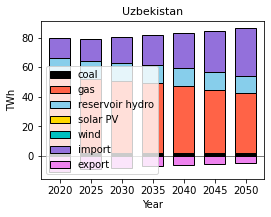

In [15]:
# Yearly results for activity (electricity generation) of Baseline
yearly_plot(base, path + "//data/results", region=["UZB"], aggregate=None)

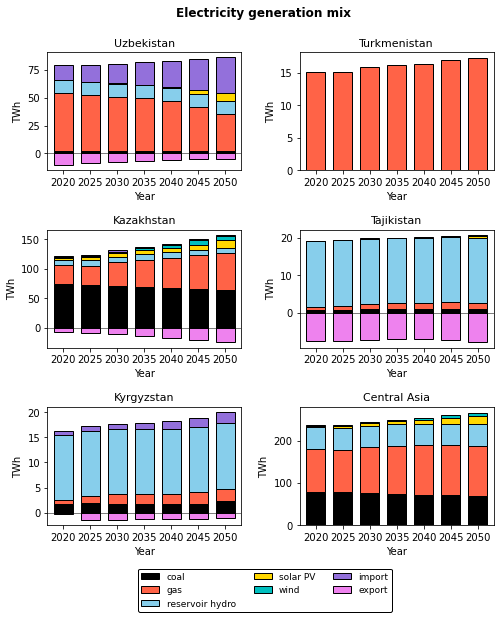

In [16]:
# Yearly results for activity (electricity generation) after changes
yearly_plot(scen, path + "//data/results")

## 3. Modeling renewable energy targets as shares
Different countries may specify targets for increasing the share of a certain technology in the system. For example, share of renewable energy in the electricity generation mix can be represented in the model to explore the implications of such a target, in terms of additional costs and emissions reduction benefits. In this section, we show how one can apply share constraints in the Central Asian energy-water model.

There are at least two ways to represent a share constraint in `message_ix`:
1. Using dedicated share constraints equations (see [documentation](https://iiasa-energy-program-message-ix.readthedocs-hosted.com/en/stable/model/MESSAGE/model_core.html#share-constraints-on-commodities) for explanation and [this example](https://github.com/iiasa/message_ix/blob/main/tutorial/westeros/westeros_share_constraint.ipynb) on how to add shares)
2. Using user-defined relations (see [documentation](https://iiasa-energy-program-message-ix.readthedocs-hosted.com/en/stable/model/MESSAGE/model_core.html#section-of-generic-relations-linear-constraints)).

In this tutorial, we follow the second approach, and we extend user-defined relations for sub-annual timeslices. 

In [17]:
# Cloning a scenario for adding shares
scen2 = base.clone(scenario="renewable_policy_1", keep_solution=False)
scen2.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


### 3.1 Adding share of renewable electricity
To add a policy target based on share of renewables in the electricity generaiton mix, we categorize power plants technologies in the model. The category `powerplant` includes all types of power plants, while `renewable_powerplant` includes renewables like wind, solar, hydro, biomass, etc. We also add a category `VRE_powerplant` to represent variable renewables like solar PV, wind, and concentrated solar power (CSP) without thermal storage.

If you are interested to see technologies under each category, you can use `cat_tec` as follows.

In [18]:
# Lisitng technologies under each category
cat = scen2.set("cat_tec")

# Technologies under "renewable powerplant"
tec_share = sorted(list(set(cat.loc[cat["type_tec"] == "renewable_powerplant"
                                ]["technology"])))
# Technologies under "powerplant"
tec_total = sorted(list(set(cat.loc[cat["type_tec"] == "powerplant"
                                ]["technology"])))
tec_share

['bio_istig',
 'bio_ppl',
 'csp_sm1_ppl',
 'csp_sm3_ppl',
 'hydro_hc',
 'hydro_lc',
 'solar_pv_ppl',
 'turbine',
 'turbine_dam',
 'wind_ppl']

Share of renewables in total electricity generation can be specified per model region and year. For example, we add this share in Kazakhstan for different years, reaching 50% of total in 2050. We use the utility function `add_share_activity` for this purpose. 

In [19]:
# Adding renewable share for Kazakhstan
relation="share_renewable"
regions = ["KAZ"]
shares = {2025: 0.15, 2030: 0.21, 2035: 0.28, 2040: 0.34, 2045: 0.43, 2050: 0.50}

# Calling function for adding the share
add_share_activity(scen2,
                   relation,            # A relation name
                   tec_share,             # Technologies formig the share (nominator)
                   tec_total,             # Technologies formig the total (denominator)
                   shares,                # A dictionary of shares per year
                   regions,               # Regions for applying the share
                  )

In [20]:
# Saving changes and solving the scenario
scen2.commit("changes saved!")
scen2.solve(solve_options={'lpmethod': '4'})

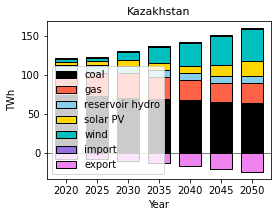

In [21]:
# Visualizing the results
yearly_plot(scen2, path, "activity", ["KAZ"], aggregate=None)

#### Renewable energy share for the region
Now, we study a case by adding a renewable share of 50% by 2050 for all five countries in Central Asia.

In [22]:
# Cloning a scenario for adding renewable share for all five countries
scen3 = base.clone(scenario="renewable_policy", keep_solution=False)
scen3.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


In [23]:
# Adding renewable share for all countries
relation="share_renewable"
regions = ["KAZ", "KGZ", "TJK", "TKM", "UZB"]
shares = {2025: 0.15, 2030: 0.21, 2035: 0.28, 2040: 0.34, 2045: 0.43, 2050: 0.50}

# Calling function for adding the share
add_share_activity(scen3,
                   relation,            # A relation name
                   tec_share,             # Technologies formig the share (nominator)
                   tec_total,             # Technologies formig the total (denominator)
                   shares,                # A dictionary of shares per year
                   regions,               # Regions for applying the share
                  )

In [24]:
# Saving changes and solving the scenario
scen3.commit("changes saved!")
scen3.solve(solve_options={'lpmethod': '4'})

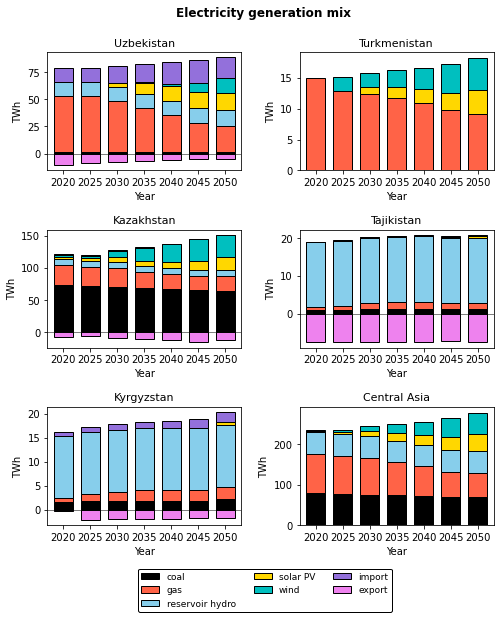

In [25]:
# Visualizing the results
yearly_plot(scen3, path, "activity")

## 4. Representation of emissions targets
Emissions targets can be modeled straightforwardly in `message_ix` using the parameter `bound_emission`. The emissions bound can be added for a certain type of technologies, like powerrplants, or for all technologies. In this section, we add total carbon emissions (TCE) bound and investigate the impact on the electricity sector.

For more information on adding emission bounds see [this example](https://github.com/iiasa/message_ix/blob/main/tutorial/westeros/westeros_emissions_bounds.ipynb), and for adding emission taxes see [this one](https://github.com/iiasa/message_ix/blob/main/tutorial/westeros/westeros_emissions_taxes.ipynb).

### 4.1 Emissions reduction target
Emissions targets are usually set as a % reduction relative to a certain year, e.g., 1990 or 2010. In this example, we add a total carbon emissions target in 2050, representing 40% reduction compared to 2020 as the reference year. We derive the reference carbon emissions from the Baseline scenario.

In [26]:
# Cloning a scenario for adding emissions targets
scen4 = base.clone(scenario="emission_policy", keep_solution=False)
scen4.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


In [27]:
# Retrieving total carbon emissions (TCE) of Central Asia (CAS) from Baseline
node = ["CAS"]       # Central Asia 
tce = base.var("EMISS", {"node": node, "emission": "TCE", "type_tec": "all"})
tce

,node,emission,type_tec,year,lvl,mrg
0,CAS,TCE,all,2020,100.883118,0.0
1,CAS,TCE,all,2025,76.611255,0.0
2,CAS,TCE,all,2030,79.763679,0.0
3,CAS,TCE,all,2035,76.409040,0.0
4,CAS,TCE,all,2040,75.349087,0.0
5,CAS,TCE,all,2045,79.283657,0.0
6,CAS,TCE,all,2050,77.856555,0.0
7,CAS,TCE,all,2055,78.069895,0.0
8,CAS,TCE,all,2060,71.581969,0.0


In [28]:
# Using TCE emissions of 2020 as the reference for 40% reduction by 2050
ref = float(tce.loc[tce["year"] == 2020]["lvl"])
target = ref * (1 - 0.4)

### 4.2 Adding new carbon emissions target
It should be noted that the unit of carbon emissions is in MtC-eq. These emissions include those from fossil fuel upstream supply chain, refineries, and the power sector. Land use emissions and emissions form the industry and heating/cooling are not included here.

In [29]:
# Adding total carbon emissions (TCE) target for Central Asia in 2050
mp.add_unit("MtC")
scen4.add_par("bound_emission", ["CAS", "TCE", "all", 2050], target, "MtC")

In [30]:
# Saving changes and solving the scenario
scen4.commit("changes saved!")
scen4.solve(solve_options={'lpmethod': '4'})

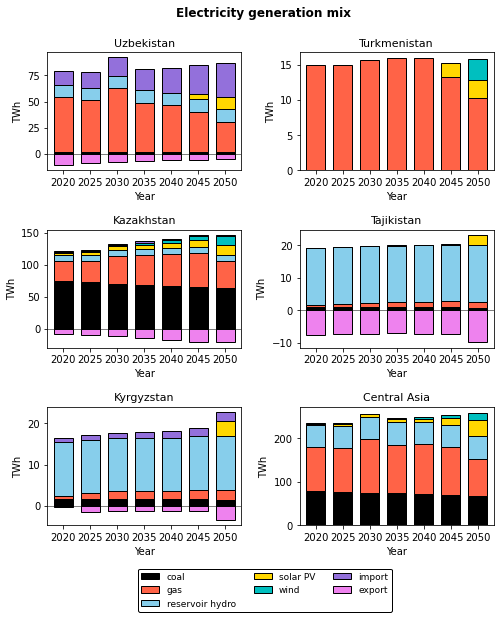

In [31]:
# Visualizing the results
yearly_plot(scen4, path, "activity")

In [ ]:
# Comparing three scenarios on total system costs and GHGs
compare_three_scenario(base, scen3, scen4,
                           scenario_names=["Baseline", "High Renewable", "Low emission"],
                           )

In [ ]:
# Close the database at the end of your work
mp.close_db()